In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from math import log10, floor
import os
import glob
import matplotlib.pyplot as plt
import datetime
from math import ceil, isnan
import sys
try:
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install --upgrade git+https://github.com/pytorch/text
    import torchtext
    from torchtext.data import Field, Iterator, Dataset

from relational_rnn_models import RelationalMemoryGenerator
from discriminator import RelGANDiscriminator

cuda = torch.cuda.is_available()

# Try setting the device to a GPU
device = torch.device("cuda:0" if cuda else "cpu")
print('Device:', device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Device: cuda:0


In [2]:
# Helper function(s)

# round a number to n significant digits
def round_to_n(x, n = 2):
    return round(x, -int(floor(log10(abs(x)))) + (n - 1)) if x != 0 else 0

# Transform a date string into a datetime object
def str_to_datetime(string):
    return datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

# TODO: more complex reduction: takes into account different ICD groups?
def reduce_icd(icd_full):
    return icd_full[:2]

def get_distribution(data, field, vocab_size, fake = True):
    counts = torch.zeros(vocab_size - 2)

    for i in range(2, vocab_size):
        if fake:
            counts[i - 2] = torch.sum(data == i)
        else:
            counts[i - 2] = field.vocab.freqs[field.vocab.itos[i]]

    freqs = counts / torch.sum(counts)
    
    return counts, freqs
    

In [3]:
%%time

filename = 'data/FINNGEN_ENDPOINTS_DF3_longitudinal_V1_for_SandBox.txt.gz'

endpoints = ['I9_HYPTENS', 'I9_ANGINA', 'I9_HEARTFAIL_NS', 'I9_STR_EXH', 'I9_CHD']

events = pd.read_csv(filename, compression = 'infer', sep='\t', nrows = 100_000_000)

print(events.columns)

# include all endpoints in a list
events = events[events['ENDPOINT'].isin(endpoints)]
#events = events.groupby('FINNGENID').filter(lambda x: len(x) > 1)

subjects = events['FINNGENID'].unique()
n_individuals = len(subjects)
print(n_individuals)
print(events['ENDPOINT'].unique())

Index(['FINNGENID', 'EVENT_AGE', 'EVENT_YEAR', 'ENDPOINT'], dtype='object')
36331
['I9_HYPTENS' 'I9_HEARTFAIL_NS' 'I9_ANGINA' 'I9_CHD' 'I9_STR_EXH']
CPU times: user 1min 3s, sys: 4.53 s, total: 1min 8s
Wall time: 1min 7s


In [4]:
%%time

print(events.groupby('FINNGENID').apply(lambda x: x['EVENT_AGE'].max() - x['EVENT_AGE'].min()).describe())
print(events.groupby('FINNGENID').apply(lambda x: len(x)).describe())

count    36331.000000
mean         8.794451
std         10.780383
min          0.000000
25%          0.000000
50%          4.160000
75%         14.770000
max         71.900000
dtype: float64
count    36331.000000
mean        11.266632
std         19.016867
min          1.000000
25%          2.000000
50%          4.000000
75%         11.000000
max        513.000000
dtype: float64
CPU times: user 9.05 s, sys: 16 ms, total: 9.06 s
Wall time: 9.05 s


In [ ]:
max_sequence_length = 5

sequence_length = min(events.groupby('FINNGENID').apply(lambda x: len(x)).max(), max_sequence_length)
print(sequence_length)

def get_sequence_of_codes(subject):
    codes = []
    
    count = 0
    for i in subject.sort_values('EVENT_AGE').index:
        codes.append(subject.loc[i, 'ENDPOINT'])
        count += 1
        if count == sequence_length:
            break
        
    res = ' '.join(codes)
    return res

def get_sequence_of_time_differences(subject):
    times = [0]
    
    count = 0
    for i in subject.sort_values('EVENT_AGE').index:
        times.append(subject.loc[i, 'EVENT_AGE'])
        count += 1
        if count == sequence_length:
            break
        
    res = np.diff(times)
    return res
    

5


In [ ]:
%%time

sequences_of_codes = events.groupby('FINNGENID').apply(get_sequence_of_codes)
#print(sequences_of_codes.head())
print(sequences_of_codes.apply(lambda x: len(x.split(' '))).describe())
print(sequences_of_codes.shape)

sequences_of_times = events.groupby('FINNGENID').apply(get_sequence_of_time_differences)
#print(sequences_of_times.head())
print(sequences_of_times.apply(lambda x: len(x)).describe())
print(sequences_of_times.shape)

count    36331.000000
mean         3.517712
std          1.611148
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          5.000000
dtype: float64
(36331,)


In [ ]:
#sequences = pd.DataFrame({'ENDPOINTS': sequences_of_codes.stack(), 'TIME_DIFFS': sequences_of_times.stack()})
sequences = pd.DataFrame({'ENDPOINTS': sequences_of_codes, 'TIME_DIFFS': sequences_of_times})
print(sequences.shape)
#sequences.head()


In [ ]:
# https://stackoverflow.com/questions/52602071/dataframe-as-datasource-in-torchtext

class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.fields = dict(fields)
        self.examples = examples.apply(SeriesExample.fromSeries, args=(self.fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
    
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [ ]:
%%time

tokenize = lambda x: x.split(' ')

ENDPOINT = Field(fix_length = sequence_length, tokenize = tokenize)

fields = [('ENDPOINTS', ENDPOINT), ('TIME_DIFFS', None)]

train_sequences, val_sequences = train_test_split(sequences, test_size = 0.1)
print(train_sequences.shape, val_sequences.shape)

train = DataFrameDataset(train_sequences, fields)
val = DataFrameDataset(val_sequences, fields)

ENDPOINT.build_vocab(train, val)

In [ ]:
print(ENDPOINT.vocab.stoi['ANY_ATC'])
print(ENDPOINT.vocab.itos[2])
vocab_size = len(ENDPOINT.vocab.freqs) + 2
print(vocab_size)

print(ENDPOINT.vocab.freqs[ENDPOINT.vocab.itos[3]])


In [ ]:
val_iter = Iterator(val, batch_size = len(val_sequences), repeat = True)

next(iter(val_iter)).ENDPOINTS.transpose(0, 1).shape

In [ ]:
%%time

def get_transition_matrix(data, vocab_size = vocab_size, d = 1, eps = 1e-20):
    transition_count = torch.zeros(vocab_size - 1, vocab_size - 1)

    for indv in data:
        for idx in range(len(indv) - d):
            i1 = idx
            i2 = i1 + d
            ep1 = indv[i1]
            ep2 = indv[i2]
            if ep1 > 0 and ep2 > 0:
                transition_count[ep1 - 1, ep2 - 1] += 1
                    
    #print(torch.sum(transition_count, dim = 1))
    transition_freq = (transition_count.transpose(0, 1) / (torch.sum(transition_count, dim = 1) + eps)).transpose(0, 1)
                    
    return transition_count, transition_freq
        
iterator = Iterator(train, batch_size = len(train_sequences))

transition_count, transition_freq = get_transition_matrix(next(iter(iterator)).ENDPOINTS.transpose(0, 1), vocab_size, d = 1)    
print(transition_count)
print(transition_freq)
print(transition_freq.sum(dim = 1))


In [ ]:
%%time

iterator = Iterator(train, batch_size = len(train_sequences))

transition_count1, transition_freq1 = get_transition_matrix(next(iter(iterator)).ENDPOINTS.transpose(0, 1), vocab_size, d = 1)    
transition_count2, transition_freq2 = get_transition_matrix(next(iter(val_iter)).ENDPOINTS.transpose(0, 1), vocab_size, d = 1)    

print(transition_freq1)
print(transition_freq2)
print((transition_freq1 - transition_freq2).abs().mean())


In [ ]:
subjects = sequences.index
n_individuals = len(subjects)
print(n_individuals)
print(vocab_size / (n_individuals * sequence_length)) # The lower this is the easier it is for the generator to learn

In [ ]:
# Test generator output

mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

start_token = torch.tensor([[0]])
memory = G.initial_state(batch_size = 1)

if cuda:
    G.cuda()
    start_token = start_token.cuda()
    memory = memory.cuda()

print(memory)
logits, tokens, _, memory = G(start_token, memory, sequence_length, None)
print(logits)
print(tokens)
print(memory)


In [ ]:
%%time

# Define generator evaluation function

def chi_sqrd_dist(counts1, counts2, separate = False, eps = 1e-20):
    counts1 = counts1.view(1, -1)
    counts2 = counts2.view(1, -1)
    table = torch.cat([counts1, counts2], dim = 0)
    col_sums = torch.sum(table, dim = 0)
    row_sums = torch.sum(table, dim = 1)
    n = torch.sum(col_sums)
    
    table_freq = table / (n + eps)
    col_freqs = col_sums / (n + eps)
    row_freqs = row_sums / (n + eps)
    
    diffs = table_freq[0, :] / (row_freqs[0] + eps) - table_freq[1, :] / (row_freqs[1] + eps)
    diffs_sqrd = diffs ** 2
    diffs_sqrd_norm = diffs_sqrd / (col_freqs + eps)
    
    if separate: 
        return diffs_sqrd_norm
    
    chi_sqrd_distance = torch.sum(diffs_sqrd_norm)
    
    return chi_sqrd_distance

def get_fake_distribution(G, start_tokens, vocab_size = vocab_size, sequence_length = sequence_length):
    memory = G.initial_state(batch_size = start_tokens.shape[0])

    if cuda:
        memory = memory.cuda()
        start_tokens = start_tokens.cuda()
    
    _, data_fake, _, _ = G(start_tokens, memory, sequence_length)
    
    counts_fake, freqs_fake = get_distribution(data_fake, None, vocab_size, fake = True)
    
    return counts_fake, freqs_fake
    
def get_score(G, ENDPOINT, start_tokens, vocab_size = vocab_size, sequence_length = sequence_length):
    counts_real, freqs_real = get_distribution(None, ENDPOINT, vocab_size, fake = False)
    
    counts_fake, freqs_fake = get_fake_distribution(G, start_tokens, vocab_size, sequence_length)
    
    score = chi_sqrd_dist(counts_real, counts_fake)
    return score

def get_transition_score(G, iterator, d = 1, separate = False, vocab_size = vocab_size, sequence_length = sequence_length):
    data = next(iter(iterator)).ENDPOINTS.transpose(0, 1)
    transition_count_real, transition_freq_real = get_transition_matrix(data, vocab_size, d)
    
    start_tokens = data[:, :1]
    memory = G.initial_state(batch_size = start_tokens.shape[0])

    if cuda:
        memory = memory.cuda()
        start_tokens = start_tokens.cuda()
    
    _, data_fake, _, _ = G(start_tokens, memory, sequence_length)
    
    transition_count_fake, transition_freq_fake = get_transition_matrix(data_fake, vocab_size, d)
    
    chi_sqrd_ds = []
    for i in range(vocab_size - 1):
        chi_sqrd_d = chi_sqrd_dist(transition_count_fake[i, :], transition_count_real[i, :])
        chi_sqrd_ds.append(chi_sqrd_d)
        
    chi_sqrd_ds = torch.tensor(chi_sqrd_ds)
    
    if separate:
        return chi_sqrd_ds
        
    return torch.mean(chi_sqrd_ds)
    
def get_aggregate_transition_score(G, iterator, separate1 = True, separate2 = True, vocab_size = vocab_size, sequence_length = sequence_length):
    scores = []
    for d in range(1, sequence_length):
        transition_score = get_transition_score(G, iterator, d, separate1, vocab_size, sequence_length)
        scores.append(transition_score)
        
    result = torch.stack(scores)
    
    if separate2:
        return result
    
    if separate1:
        return torch.mean(result, dim = 0)
    else:
        return torch.mean(result)

val_data = next(iter(val_iter)).ENDPOINTS.transpose(0, 1)

score = get_score(G, ENDPOINT, val_data[:, :1])
print(score)

transition_score = get_transition_score(G, val_iter, d = 1, separate = True)
print(transition_score)

aggr_transition_score = get_aggregate_transition_score(G, val_iter, True, True)
print(aggr_transition_score)


In [ ]:
# Test Discriminator output

n_embeddings = 2
embed_size = 2
out_channels = 5 
filter_sizes = [2, 3] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    D.cuda()

inp = logits
print(inp)
print(D(inp, False))
print(D(inp))


In [ ]:
# Define the generator pre-train function

def pretrain_generator(G, train, batch_size, vocab_size, sequence_length, n_epochs, lr, print_step = 10):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        loss_function.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        loss_total = 0
        count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINTS.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)
            
            start_token = train_data[:, :1]
            optimizer.zero_grad()

            memory = G.initial_state(batch_size = train_data.shape[0])

            if cuda:
                start_token = start_token.cuda()
                memory = memory.cuda()
                
            logits, _, _, _ = G(start_token, memory, sequence_length, 1.0)

            loss = loss_function(logits, train_data_one_hot)
            
            loss_total += loss.item()
            count += 1

            loss.backward()
            optimizer.step()
            
        
        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [G loss: %f]"
                % (e, n_epochs, loss_total / count)
            )

In [19]:
mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

if cuda:
    G.cuda()
    
val_data = next(iter(val_iter)).ENDPOINTS.transpose(0, 1)

score = get_score(G, ENDPOINT, val_data[:, :1])
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val_iter, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

batch_size = 64
pretrain_generator(G, train, batch_size, vocab_size, sequence_length, 3, 0.01, print_step = 1)

score = get_score(G, ENDPOINT, val_data[:, :1])
print(score)
aggr_transition_score = get_aggregate_transition_score(G, val_iter, True, True)
print(aggr_transition_score)
print(aggr_transition_score.mean())

tensor([[1.5376, 0.1031, 0.5355, 0.8933, 0.3657, 1.1597],
        [1.2815, 0.0360, 0.2964, 0.6004, 0.1523, 0.8337],
        [1.2941, 0.0157, 0.1351, 0.3025, 0.1056, 0.4494],
        [0.0000, 0.0119, 0.0651, 0.1903, 0.0165, 0.4187]])
tensor(0.4500)


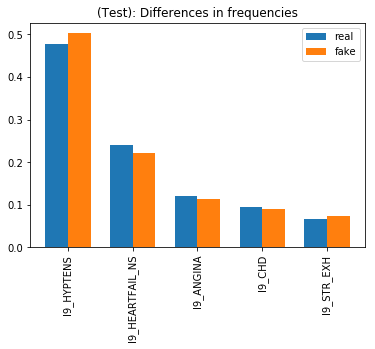

In [20]:
def save_grouped_barplot(freqs, freqs_fake, idx, title, N=10):
    freqs1 = freqs.numpy()[idx]
    freqs2 = freqs_fake.numpy()[idx]

    fig, ax = plt.subplots(figsize=(6,6))

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, freqs1, width, bottom=0)

    p2 = ax.bar(ind + width, freqs2, width, bottom=0)

    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(map(lambda x: ENDPOINT.vocab.itos[x], idx + 2), rotation=90)

    ax.legend((p1[0], p2[0]), ('real', 'fake'))
    ax.autoscale_view()
    
    fig.subplots_adjust(bottom=0.36)
    fig.savefig('figs/' + '_'.join(title.split(' ')).translate({ord(i): None for i in ':()'}) + '.svg')
    
def save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix='', N_max=10):
    N = min(N_max, vocab_size - 2)
    if not prefix == '':
        prefix += ' '
    
    if N == vocab_size - 2:
        idx = np.arange(N)
        
        title = prefix + 'Differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    else:
        abs_diffs = np.abs(freqs - freqs_fake)
        idx = np.argsort(abs_diffs)[-N:]
        idx = np.flip(idx)
        
        title = prefix + 'Largest absolute differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)

        chi_sqrd_dists = chi_sqrd_dist(counts, counts_fake, separate = True)
        idx = np.argsort(chi_sqrd_dists)[-N:]
        idx = np.flip(idx)

        title = prefix + 'Largest relative differences in frequencies'
        save_grouped_barplot(freqs, freqs_fake, idx, title, N)
    

train_iter = Iterator(train, batch_size = len(train_sequences))
train_data = next(iter(train_iter)).ENDPOINTS.transpose(0, 1)
    
counts, freqs = get_distribution(None, ENDPOINT, vocab_size, fake = False)
counts_fake1, _ = get_fake_distribution(G, val_data[:, :1])
counts_fake2, _ = get_fake_distribution(G, train_data[:, :1])

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = '(Test):'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

In [21]:
# Define the training function

def get_scores(G, ENDPOINT, iterator, separate1 = True, separate2 = True, vocab_size = vocab_size, sequence_length = sequence_length):
    start_tokens = next(iter(iterator)).ENDPOINTS.transpose(0, 1)[:, :1]
    
    score1 = get_score(G, ENDPOINT, start_tokens, vocab_size, sequence_length)
    
    score2 = get_aggregate_transition_score(G, iterator, separate1, separate2, vocab_size, sequence_length)
    
    return score1, score2.mean(), score2

def train_GAN(G, D, train, val_iter, batch_size, vocab_size, sequence_length, \
              n_epochs, lr, temperature, print_step = 10, score_fn = get_scores):    
    scores = []
    accuracies_real = []
    accuracies_fake = []
    
    score = score_fn(G, ENDPOINT, val_iter)
    print('Scores before training:', *score)
    scores.append(score)
    
    print('pretraining generator...')
    pretrain_generator(G, train, batch_size, vocab_size, sequence_length, max(n_epochs // 10, 1), \
                       lr * 100, print_step = max(n_epochs // 10 - 1, 1))
    print('pretraining complete')
    
    score = score_fn(G, ENDPOINT, val_iter)
    print("[Scores:", *score, "]")
    scores.append(score)
    
    adversarial_loss = torch.nn.BCELoss()
    
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
    
    if cuda:
        G.cuda()
        D.cuda()
        adversarial_loss.cuda()
    
    for e in range(n_epochs):
        train_iter = Iterator(train, batch_size = batch_size, device = device)
        #loss_total = 0
        #count = 0
        
        for batch in train_iter:
            train_data = batch.ENDPOINTS.transpose(0, 1)
            train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)

            start_token = train_data[:, :1]
            
            # Adversarial ground truths
            valid = Variable(Tensor(train_data.shape[0]).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(train_data.shape[0]).fill_(0.0), requires_grad=False)

            optimizer_G.zero_grad()

            # Generate a batch of images
            memory = G.initial_state(batch_size = train_data.shape[0])
            if cuda:
                memory = memory.cuda()

            temp = temperature ** ((e + 1) / n_epochs)
            fake_one_hot, _, _, _ = G(start_token, memory, sequence_length, temp)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(D(fake_one_hot).view(-1), valid)

            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            D_out_real = D(train_data_one_hot).view(-1)
            D_out_fake = D(fake_one_hot.detach()).view(-1)
            
            #print(D_out_real)
            #print(torch.round(D_out_real))
            accuracy_real = torch.mean(D_out_real)
            accuracy_fake = torch.mean(1 - D_out_fake)
            
            real_loss = adversarial_loss(D_out_real, valid)
            fake_loss = adversarial_loss(D_out_fake, fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        if e % print_step == 0:
            print()
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f] [Acc real: %f] [Acc fake: %f]"
                % (e, n_epochs, d_loss.item(), g_loss.item(), accuracy_real, accuracy_fake)
            )
            score = score_fn(G, ENDPOINT, val_iter)
            print("[Scores:", *score, "]")
            scores.append(score)
            accuracies_real.append(accuracy_real)
            accuracies_fake.append(accuracy_fake)
            
    score = score_fn(G, ENDPOINT, val_iter)
    print('Scores after training:', *score)
    scores.append(score)
            
    output = [[] for _ in range(len(scores[0]))]
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            output[j].append(scores[i][j])

    output.append(accuracies_real)
    output.append(accuracies_fake)
            
    for j in range(len(output)):
        output[j] = torch.stack(output[j])
            
    return tuple(output)


Scores before training: tensor(1.1284) tensor(1.7545) tensor([[4.3715, 1.7107, 2.2080, 0.8063, 0.5120, 1.5271],
        [3.8799, 1.6898, 2.0626, 1.1278, 0.6848, 1.3916],
        [3.4009, 1.8339, 2.1153, 1.1812, 1.1167, 1.3419],
        [0.0000, 1.9264, 2.1525, 1.8350, 1.4158, 1.8176]])
pretraining generator...
[Epoch 0/1] [G loss: 4.247199]
pretraining complete
[Scores: tensor(0.0113) tensor(0.3938) tensor([[1.3958, 0.1317, 0.4593, 0.6488, 0.5042, 0.7387],
        [1.3086, 0.1006, 0.2818, 0.3659, 0.3833, 0.5266],
        [1.3643, 0.0600, 0.1057, 0.3076, 0.1804, 0.1516],
        [0.0000, 0.0318, 0.0590, 0.1169, 0.0782, 0.1516]]) ]

[Epoch 0/10] [D loss: 0.672251] [G loss: 0.755522] [Acc real: 0.538488] [Acc fake: 0.512574]
[Scores: tensor(0.0837) tensor(0.5618) tensor([[0.4594, 0.1902, 0.2333, 0.6326, 0.4428, 1.4539],
        [0.4604, 0.2460, 0.3470, 0.3439, 0.6523, 1.0467],
        [0.5097, 0.3339, 0.6244, 0.4765, 0.5066, 0.8795],
        [0.0000, 0.3168, 0.9910, 0.6066, 0.8743, 0.8565

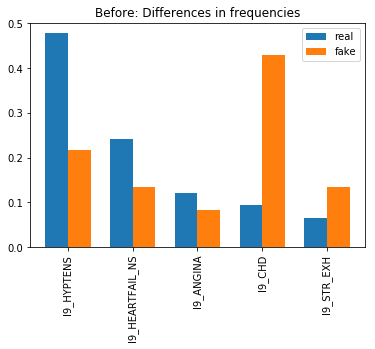

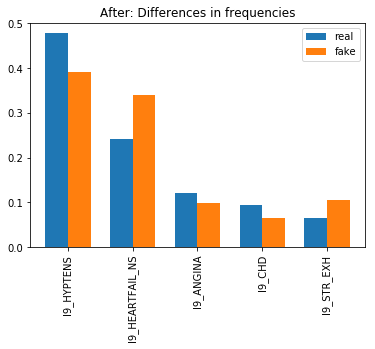

In [22]:
# Train the GAN

start_time = time.time()

# Generator params
mem_slots = 1
head_size = 6
embed_size = 10
temperature = 5
num_heads = 10
num_blocks = 6

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads, num_blocks)

# Discriminator params
n_embeddings = 5
embed_size = embed_size
out_channels = 15
filter_sizes = [2, 3, 4] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    G.cuda()
    D.cuda()

counts_fake1, _ = get_fake_distribution(G, val_data[:, :1])
counts_fake2, _ = get_fake_distribution(G, train_data[:, :1])

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

N_max = 10
prefix = 'Before:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)



batch_size = 64
n_epochs = 10
print_step = max(n_epochs // 10, 1)
lr = 1e-4

# Train the GAN
scores1, scores2, scores3, accuracies_real, accuracies_fake = train_GAN(
    G, D, train, val_iter, batch_size, vocab_size, sequence_length, n_epochs, lr, temperature, print_step
)



counts_fake1, _ = get_fake_distribution(G, val_data[:, :1])
counts_fake2, _ = get_fake_distribution(G, train_data[:, :1])

counts_fake = counts_fake1 + counts_fake2
freqs_fake = counts_fake / torch.sum(counts_fake)

prefix = 'After:'

save_relative_and_absolute(freqs, freqs_fake, counts, counts_fake, vocab_size, prefix, N_max)

print('Time taken:', round_to_n(time.time() - start_time, n = 3), 'seconds')


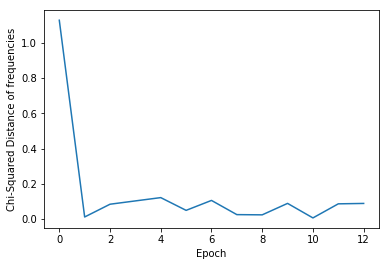

In [23]:
%matplotlib inline

plt.plot(range(scores1.shape[0]), scores1.numpy())
plt.ylabel('Chi-Squared Distance of frequencies')
plt.xlabel('Epoch')
plt.savefig('figs/chisqrd_freqs.svg')

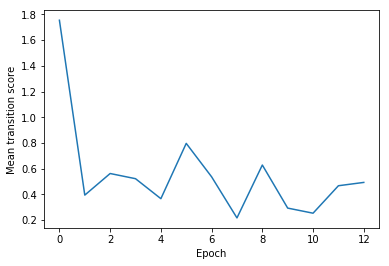

In [24]:
plt.plot(range(scores2.shape[0]), scores2.numpy())
plt.ylabel('Mean transition score')
plt.xlabel('Epoch')
plt.savefig('figs/mean_transition_score.svg')

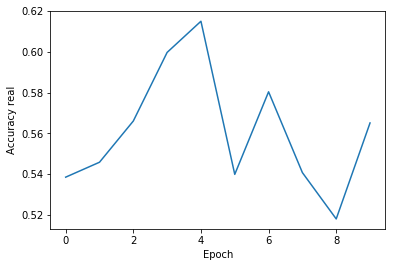

In [25]:
plt.plot(range(accuracies_real.shape[0]), accuracies_real.detach().cpu().numpy())
plt.ylabel('Accuracy real')
plt.xlabel('Epoch')
plt.savefig('figs/accuracy_real.svg')

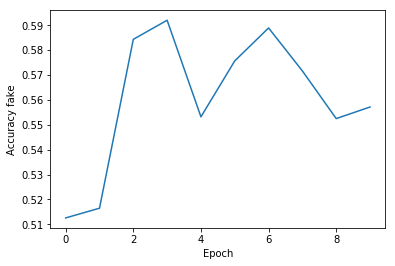

In [26]:
plt.plot(range(accuracies_fake.shape[0]), accuracies_fake.detach().cpu().numpy())
plt.ylabel('Accuracy fake')
plt.xlabel('Epoch')
plt.savefig('figs/accuracy_fake.svg')

In [27]:
for d in range(1, sequence_length):
    plt.plot(range(scores3.shape[0]), scores3[:, d - 1, :].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'd=' + str(d)
    plt.title(title)
    labels = [ENDPOINT.vocab.itos[i] for i in range(1, vocab_size)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [28]:
for v in range(1, vocab_size):
    plt.plot(range(scores3.shape[0]), scores3[:, :, v - 1].numpy())
    plt.ylabel('Transition score')
    plt.xlabel('Epoch')
    title = 'enpoint=' + ENDPOINT.vocab.itos[v]
    plt.title(title)
    labels = ['d=' + str(i) for i in range(1, sequence_length)]
    plt.legend(labels)
    plt.savefig('figs/' + title + '.svg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [29]:
test_size = 10
start_tokens = torch.randint(2, vocab_size, (test_size, 1))
print(start_tokens)

memory = G.initial_state(batch_size = test_size)

if cuda:
    memory = memory.cuda()
    start_tokens = start_tokens.cuda()
    
_, data_fake, _, _ = G(start_tokens, memory, sequence_length)

data_fake

tensor([[6],
        [2],
        [3],
        [2],
        [5],
        [3],
        [4],
        [4],
        [6],
        [6]])


tensor([[6, 6, 6, 6, 6],
        [2, 2, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [2, 3, 3, 3, 3],
        [5, 4, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [4, 5, 4, 4, 5],
        [4, 2, 4, 4, 4],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6]], device='cuda:0')